In [5]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from datetime import datetime
import random

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
from scipy.stats import boxcox, norm
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

# library for sampling
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

# library for machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import shap
# %matplotlib inline # Matplotlib의 시각화 결과를 노트북 내에서 바로 표시되도록 설정


In [ ]:
!kaggle competitions download -c home-credit-default-risk

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
stealthtechnologies/predict-student-performance-dataset          Predict Student Performance                          12KB  2024-12-26 12:57:04           1393         39  1.0              
bhadramohit/customer-shopping-latest-trends-dataset              Customer Shopping (Latest Trends) Dataset            76KB  2024-11-23 15:26:12          21891        409  1.0              
ankushpanday1/heart-attack-in-youth-of-india                     Heart attack in youth of India                      298KB  2025-01-02 15:20:31            847         27  1.0              
oktayrdeki/heart-disease                               


  0%|          | 0.00/688M [00:00<?, ?B/s]
  0%|          | 1.00M/688M [00:00<03:31, 3.40MB/s]
  0%|          | 2.00M/688M [00:00<02:10, 5.51MB/s]
  1%|          | 4.00M/688M [00:00<01:25, 8.42MB/s]
  1%|          | 5.00M/688M [00:00<01:21, 8.82MB/s]
  1%|          | 7.00M/688M [00:00<01:11, 10.0MB/s]
  1%|▏         | 9.00M/688M [00:01<01:06, 10.7MB/s]
  2%|▏         | 11.0M/688M [00:01<01:04, 11.1MB/s]
  2%|▏         | 13.0M/688M [00:01<01:03, 11.2MB/s]
  2%|▏         | 15.0M/688M [00:01<01:05, 10.8MB/s]
  2%|▏         | 17.0M/688M [00:01<01:03, 11.1MB/s]
  3%|▎         | 19.0M/688M [00:02<01:11, 9.86MB/s]
  3%|▎         | 21.0M/688M [00:02<01:07, 10.4MB/s]
  3%|▎         | 23.0M/688M [00:02<01:04, 10.8MB/s]
  4%|▎         | 25.0M/688M [00:02<01:02, 11.1MB/s]
  4%|▍         | 27.0M/688M [00:02<01:01, 11.3MB/s]
  4%|▍         | 29.0M/688M [00:02<01:00, 11.5MB/s]
  5%|▍         | 31.0M/688M [00:03<00:59, 11.6MB/s]
  5%|▍         | 33.0M/688M [00:03<00:58, 11.7MB/s]
  5%|▌         | 35.

In [16]:
import zipfile
import os

# ZIP 파일 경로와 압축을 풀 폴더 경로
zip_file_path = 'home-credit-default-risk.zip'  # ZIP 파일 이름
extract_to = 'home-credit-default-risk_files'  # 압축을 풀 폴더 이름

# 압축 해제 과정
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 압축을 풀 폴더가 없는 경우 생성
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    # 압축 해제 실행
    zip_ref.extractall(extract_to)

In [17]:
df = pd.read_csv("./home-credit-default-risk_files/application_train.csv", delimiter=",")
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# 중복 data 확인 및 제거

print("중복된 항목 수 :", len(df[df.duplicated()]))

has_duplicated = len(df[df.duplicated()]) != 0
if (has_duplicated):
  df = df.drop_duplicates()

중복된 항목 수 : 0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [20]:
df.isna().sum()
df.dropna(axis=1, inplace=True)

In [21]:
# categorical and numeric columns
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

SK_ID_CURR int64 [100002 100003 100004 ... 456253 456254 456255]
TARGET int64 [1 0]
NAME_CONTRACT_TYPE object ['Cash loans' 'Revolving loans']
CODE_GENDER object ['M' 'F' 'XNA']
FLAG_OWN_CAR object ['N' 'Y']
FLAG_OWN_REALTY object ['Y' 'N']
CNT_CHILDREN int64 [ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14]
AMT_INCOME_TOTAL float64 [202500.  270000.   67500.  ...  96768.  546250.5 113062.5]
AMT_CREDIT float64 [ 406597.5 1293502.5  135000.  ...  181989.   743863.5 1391130. ]
NAME_INCOME_TYPE object ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE object ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS object ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE object ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apart

In [22]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64','int64']).columns)
target_column = "TARGET"
print(len(df))
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

307511
55
10
45


In [23]:
df.isna().sum()

SK_ID_CURR                     0
TARGET                         0
NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
REGION_POPULATION_RELATIVE     0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
WEEKDAY_APPR_PROCESS_START     0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGIO

### 2-2 Dependent(종속) Data Explore

In [24]:
list_categorical_columns.remove(target_column)

ValueError: list.remove(x): x not in list

In [25]:
df[target_column].describe()

count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64

In [26]:
df[target_column].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

<Axes: xlabel='TARGET', ylabel='count'>

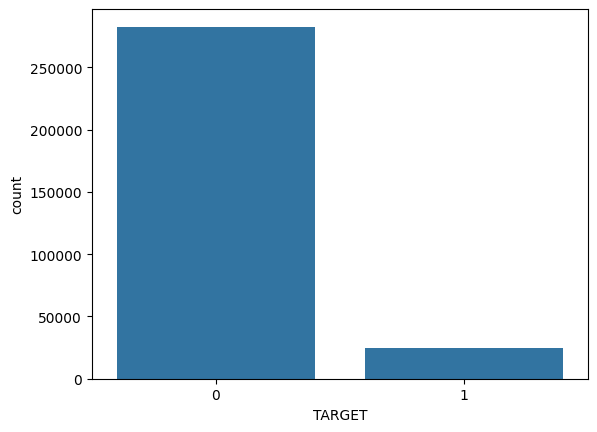

In [27]:
sns.countplot(x=target_column, data=df)

### 2-3 Independent(독립) Data Explore

In [28]:
df[list_categorical_columns].nunique().sort_values()
# 불필요한 컬럼 보이지 않음

NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
CODE_GENDER                    3
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
NAME_INCOME_TYPE               8
ORGANIZATION_TYPE             58
dtype: int64

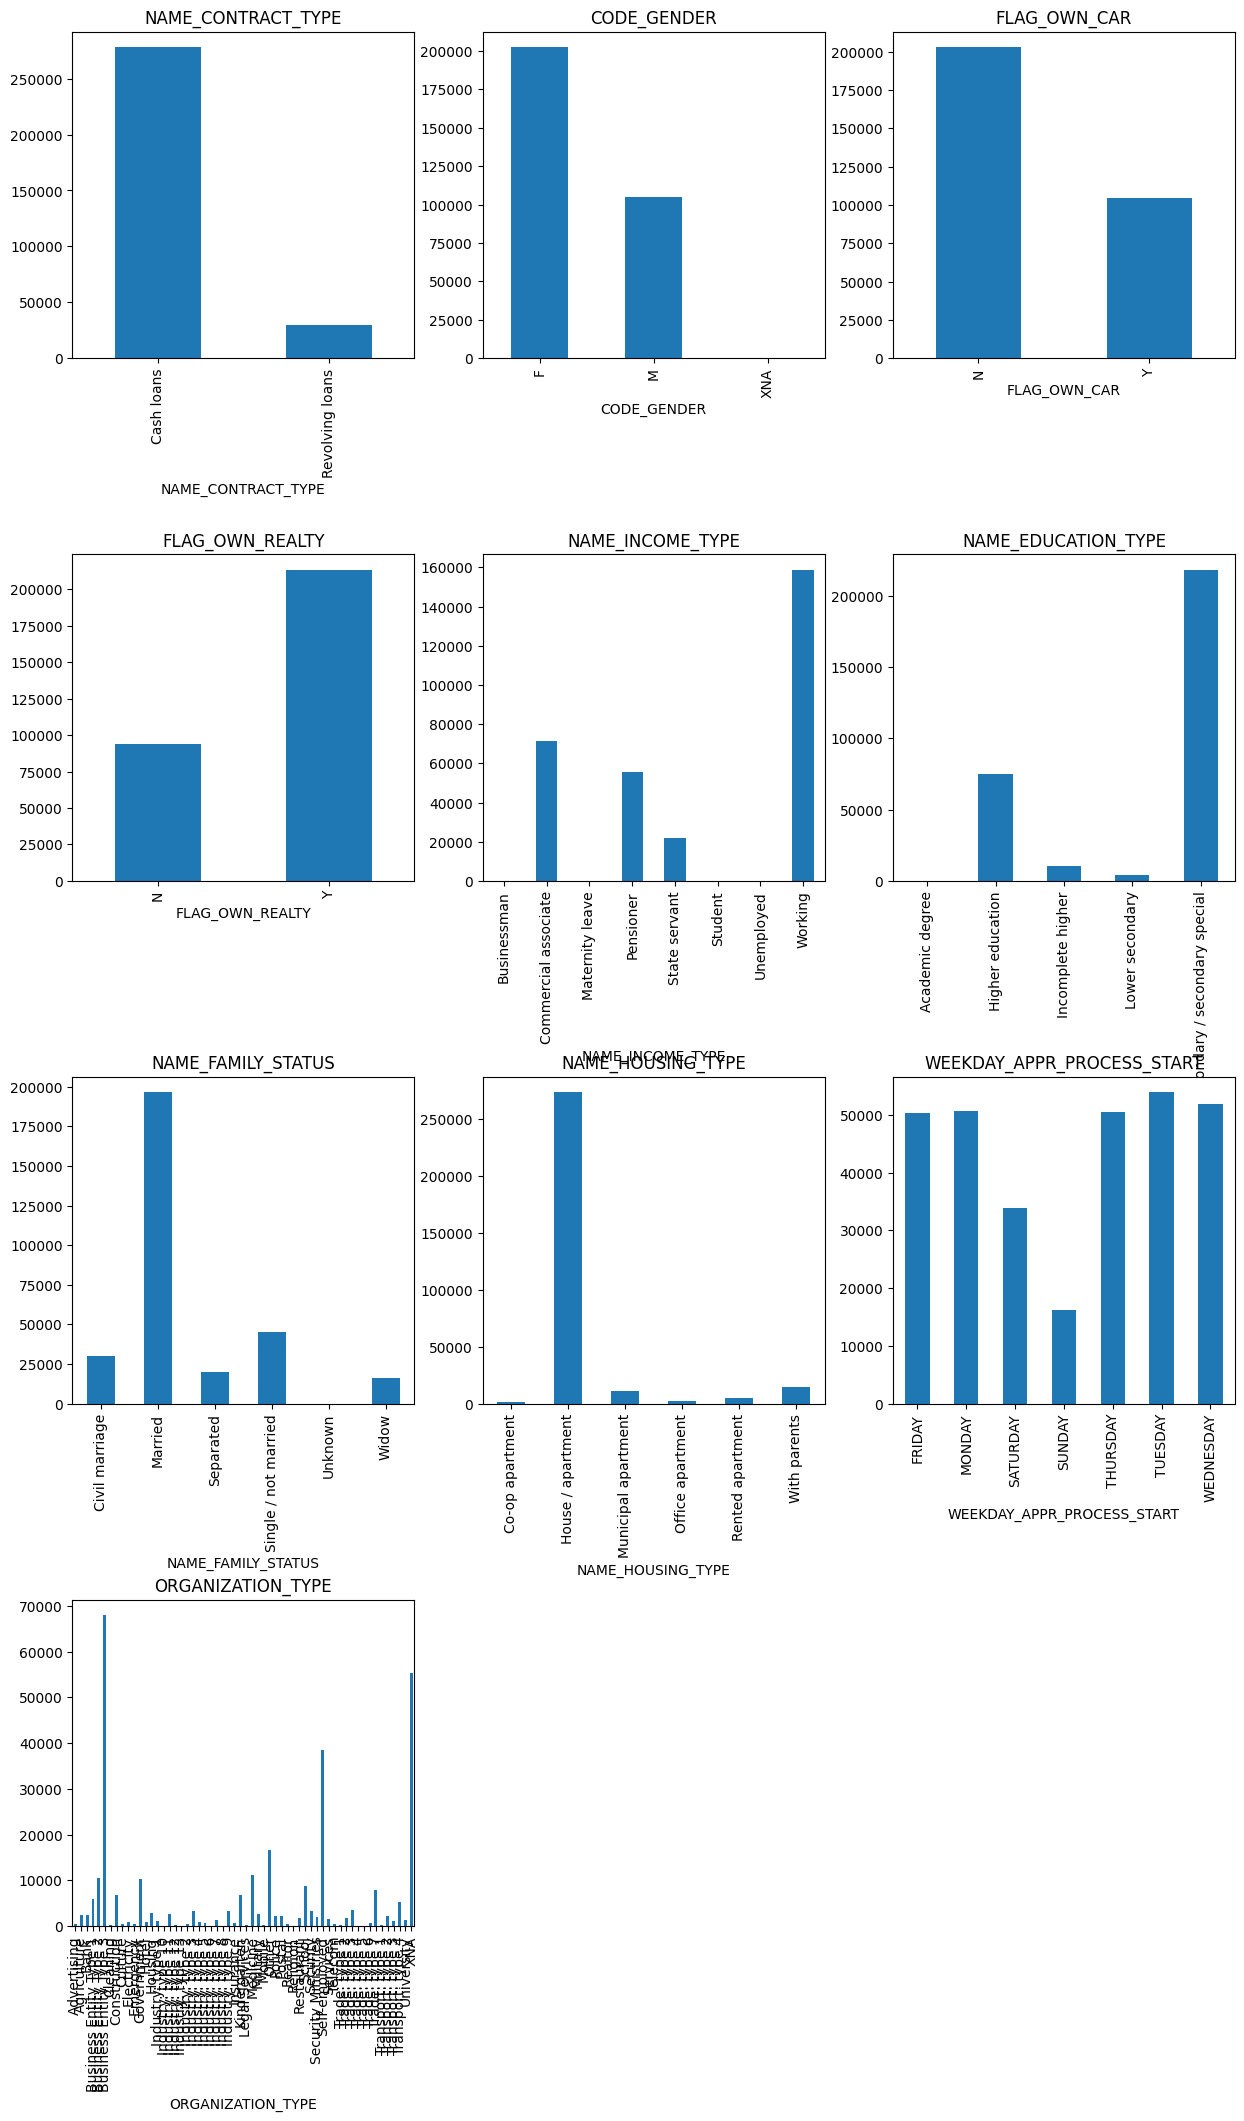

In [29]:
# cateogircla column 별 분포 확인
plt.figure(figsize=(15,30))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.6, wspace=0.2)
for column_name in list_categorical_columns:
    plt.subplot(6,3,x)
    x = x+1
    df[column_name].value_counts().sort_index().plot(kind='bar')
    plt.title(column_name)
plt.show()

<Axes: xlabel='TARGET'>

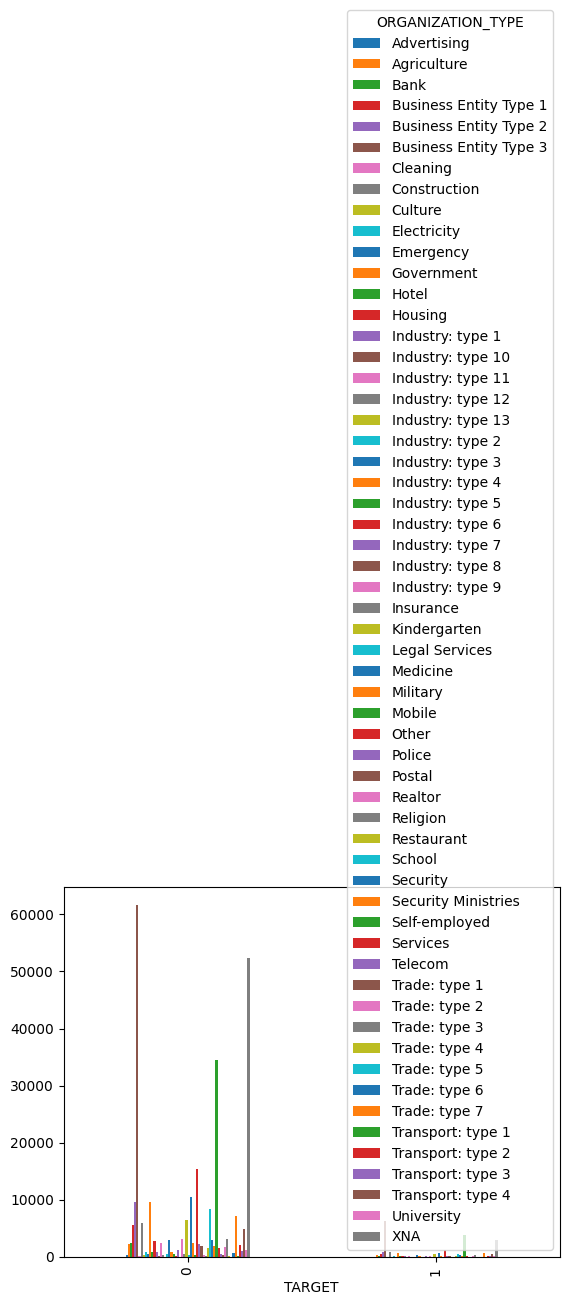

In [30]:
# categorical column과 dependent data(target column) 분포 분석
df_poutcome_dependent = pd.crosstab(df[target_column], df[list_categorical_columns[-1]])
df_poutcome_dependent.plot(kind='bar')
# 애초에 target_column(y) 비중이 다르기 때문에, 아래와 같이 count 수를 비교하는 것은 데이터 분포를 파악하는데 적합하지 않음

In [31]:
# 아래와 같은 table을 출력
pd.crosstab(df[target_column], df[list_categorical_columns[-1]], normalize="index")

ORGANIZATION_TYPE,Advertising,Agriculture,Bank,Business Entity Type 1,Business Entity Type 2,Business Entity Type 3,Cleaning,Construction,Culture,Electricity,...,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,XNA
TARGET,,,,,,,,,,,,,,,,,,,,,
0,0.001394,0.007772,0.008409,0.019446,0.034147,0.218154,0.000817,0.020999,0.001266,0.003138,...,0.000219,0.000163,0.002130,0.025084,0.000679,0.007188,0.003537,0.017323,0.004464,0.185308
1,0.001410,0.010352,0.005237,0.019617,0.036254,0.254703,0.001168,0.031621,0.000846,0.002538,...,0.000081,0.000121,0.001168,0.029809,0.000363,0.006928,0.007533,0.020181,0.002618,0.120443


<Axes: xlabel='TARGET'>

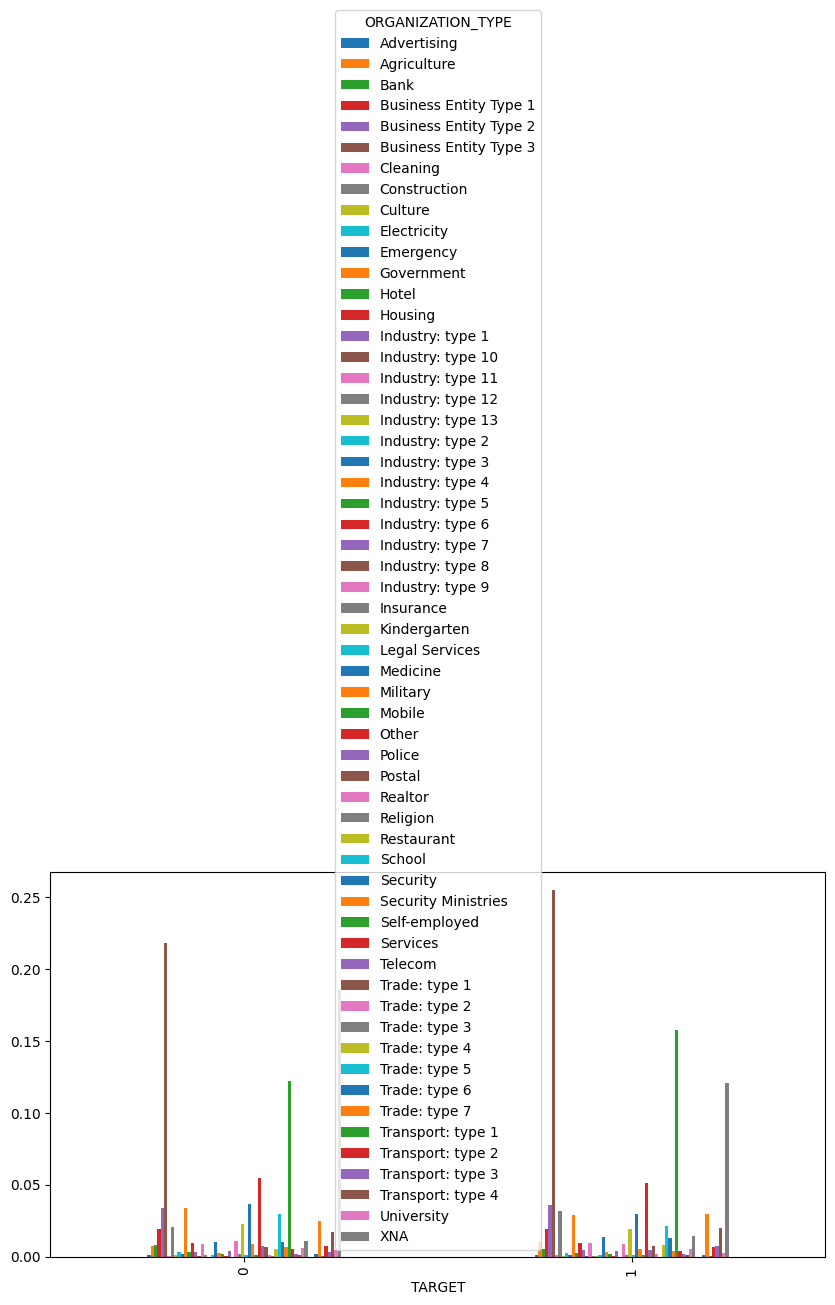

In [32]:
df_poutcome_dependent_ratio = pd.crosstab(df[target_column], df[list_categorical_columns[-1]], normalize="index")
df_poutcome_dependent_ratio.plot.bar(figsize=(10,5))

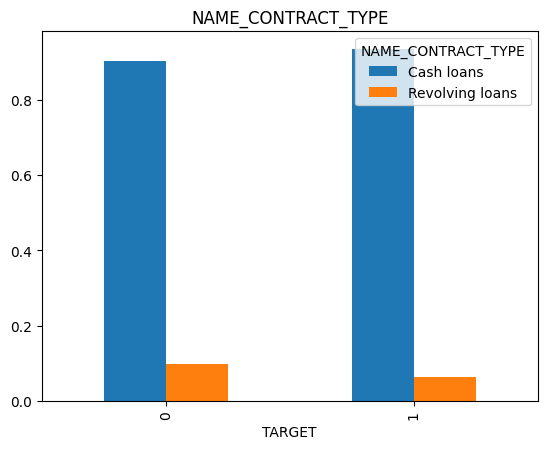

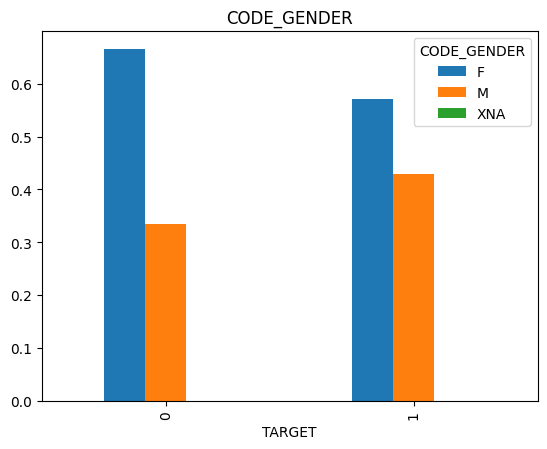

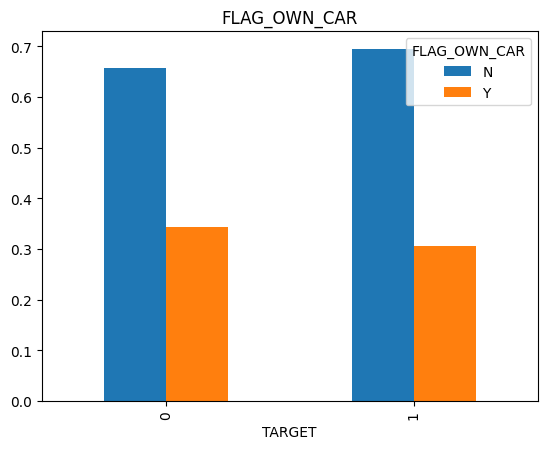

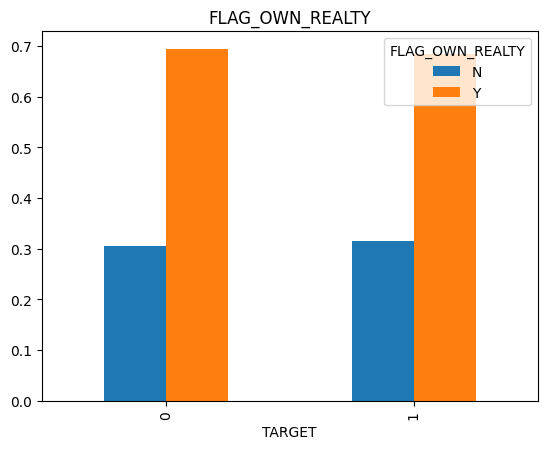

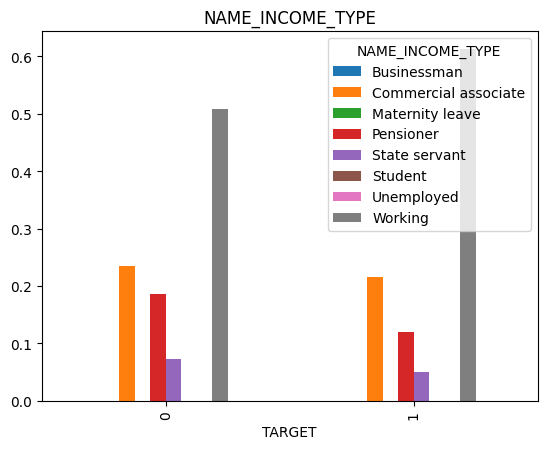

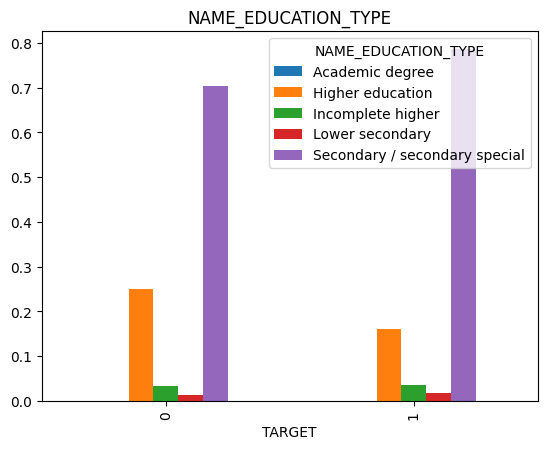

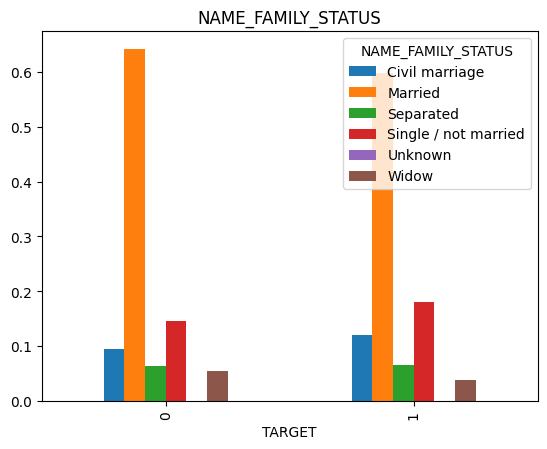

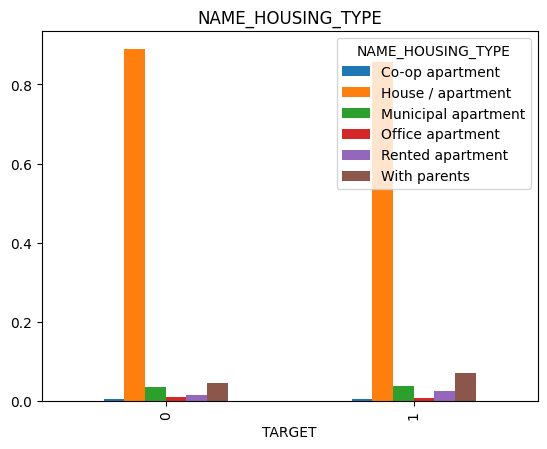

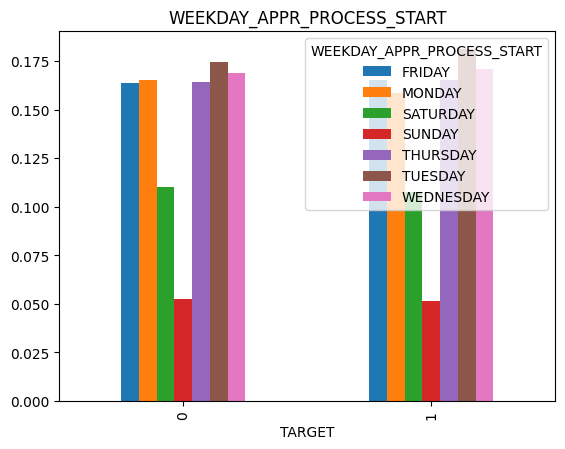

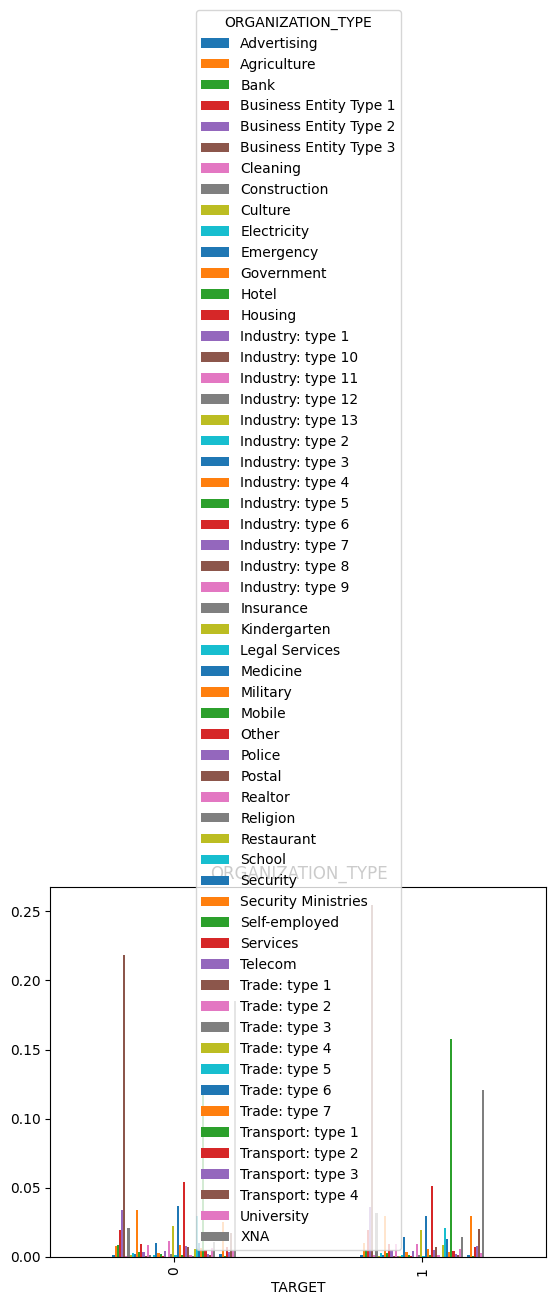

In [33]:
# 이런 경우에는 비율 데이터를 plot으로 그리면 데이터 분포 이해에 도움.
for column_name in list_categorical_columns:
    pd.crosstab(df[target_column], df[column_name], normalize="index").plot.bar()
    plt.title(column_name)
plt.show()

In [34]:
# 카이제곱 검정 코드
list_meaningful_column_by_chi = []

for column_name in list_categorical_columns:
  statistic, pvalue, _, _ = chi2_contingency(pd.crosstab(df[target_column], df[column_name]))
  if pvalue <= 0.05:
    list_meaningful_column_by_chi.append(column_name)
  print(column_name, statistic, pvalue)

print("all categorical columns : ", len(list_categorical_columns))
print("selected columns by chi : ", len(list_meaningful_column_by_chi), list_meaningful_column_by_chi)

NAME_CONTRACT_TYPE 293.15054219964554 1.0235150721172847e-65
CODE_GENDER 920.7913340361749 1.1290217848908289e-200
FLAG_OWN_CAR 146.65601825576024 9.330994431109667e-34
FLAG_OWN_REALTY 11.575827298084178 0.0006681470317545887
NAME_INCOME_TYPE 1253.4708080924988 1.9281456056858933e-266
NAME_EDUCATION_TYPE 1019.2131873088356 2.4476812052198174e-219
NAME_FAMILY_STATUS 504.69408255632106 7.744841561414258e-107
NAME_HOUSING_TYPE 420.55618983894664 1.0990890032617707e-88
WEEKDAY_APPR_PROCESS_START 15.38755691304465 0.017447369313895057
ORGANIZATION_TYPE 1609.2406359645206 5.224541090300173e-299
all categorical columns :  10
selected columns by chi :  10 ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']


#### 2) Numeric Data Analysis

In [35]:
df[list_numeric_columns].nunique().sort_values()

REG_CITY_NOT_LIVE_CITY              2
LIVE_CITY_NOT_WORK_CITY             2
FLAG_DOCUMENT_2                     2
FLAG_DOCUMENT_3                     2
FLAG_DOCUMENT_4                     2
FLAG_DOCUMENT_5                     2
FLAG_DOCUMENT_6                     2
FLAG_DOCUMENT_7                     2
FLAG_DOCUMENT_8                     2
FLAG_DOCUMENT_9                     2
FLAG_DOCUMENT_10                    2
FLAG_DOCUMENT_11                    2
FLAG_DOCUMENT_12                    2
FLAG_DOCUMENT_13                    2
FLAG_DOCUMENT_14                    2
FLAG_DOCUMENT_15                    2
FLAG_DOCUMENT_16                    2
FLAG_DOCUMENT_17                    2
FLAG_DOCUMENT_18                    2
FLAG_DOCUMENT_19                    2
REG_CITY_NOT_WORK_CITY              2
FLAG_DOCUMENT_20                    2
FLAG_DOCUMENT_21                    2
REG_REGION_NOT_WORK_REGION          2
TARGET                              2
LIVE_REGION_NOT_WORK_REGION         2
FLAG_EMP_PHO

In [36]:
df[list_numeric_columns].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,...,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,...,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,-3254.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,0.028663,-12413.000000,-289.000000,-2010.000000,-1720.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


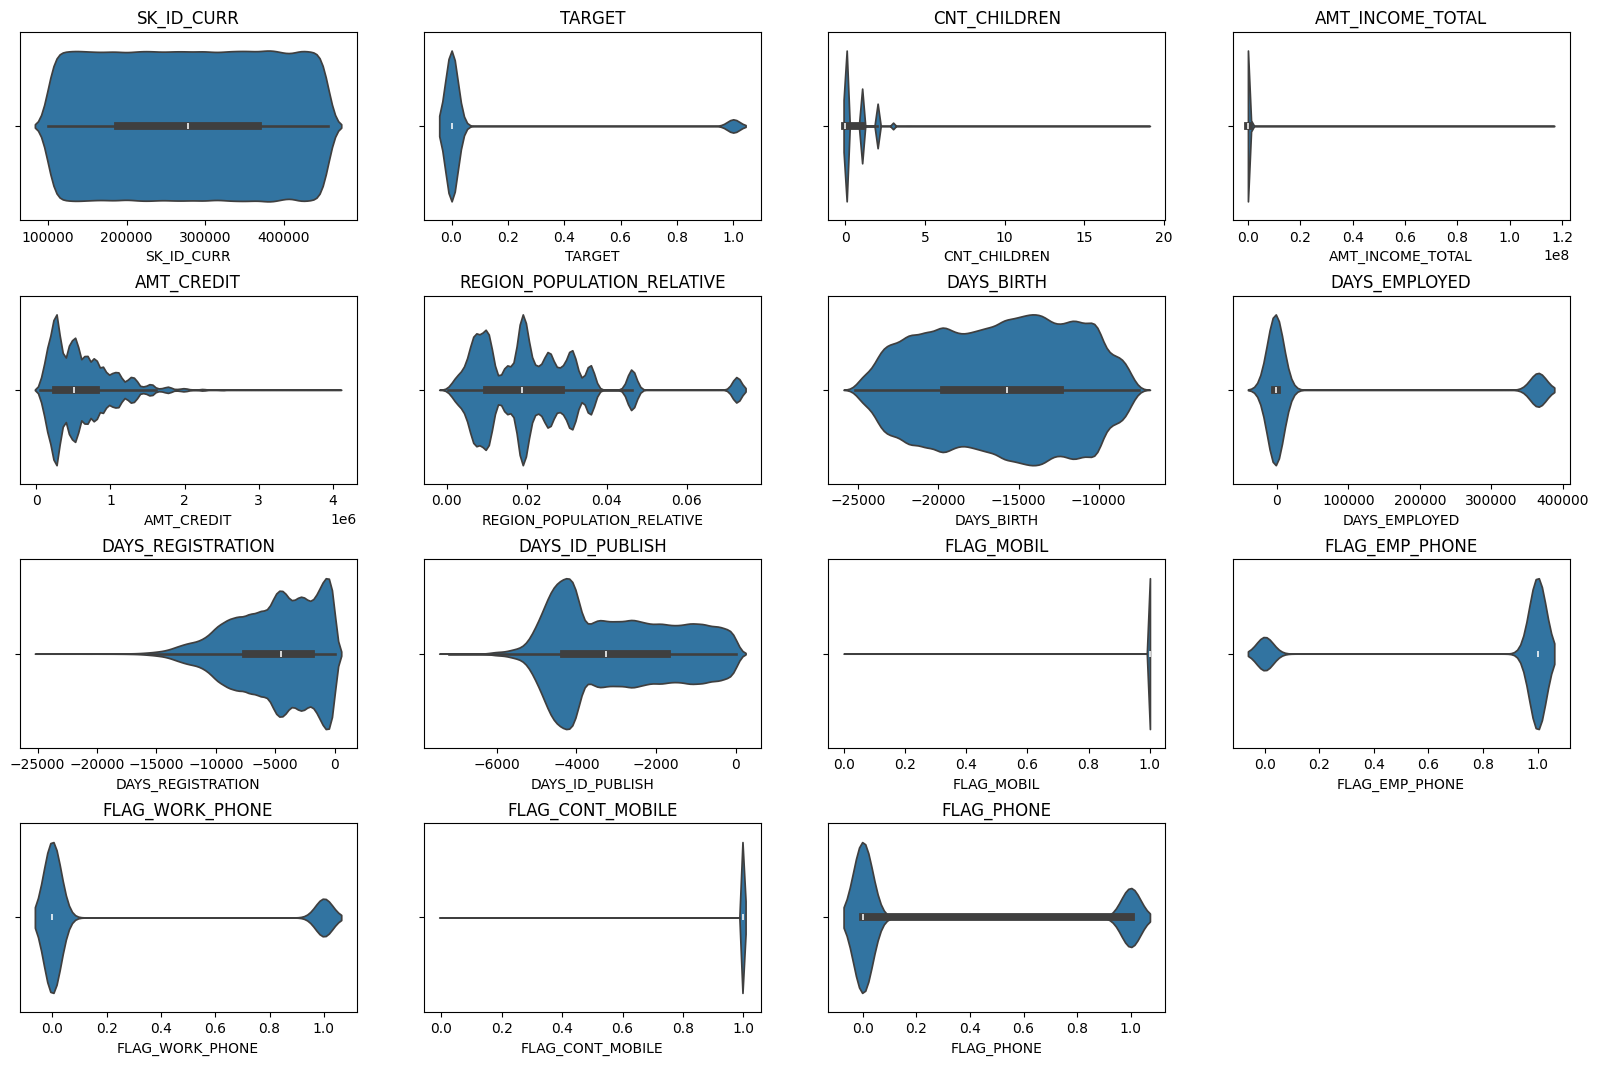

In [37]:
# numeric column 별 분포 확인
plt.figure(figsize=(20,10))
x = 1

plt.subplots_adjust(top=0.99, bottom = 0.01, hspace = 0.4, wspace=0.2)
for column_name in list_numeric_columns[:15]:
  plt.subplot(4,4,x)
  x = x + 1
  sns.violinplot(x=column_name, data=df)
  plt.title(column_name)
plt.show()

In [38]:
for column_name in list_numeric_columns:
  print(column_name, "skew : ", skew(df[column_name]), "kur : ", kurtosis(df[column_name]) )

# 추후 scaling을 활용한 feature preprocessing의 필요성 확인

SK_ID_CURR skew :  -0.001200229222216958 kur :  -1.1989877943832548
TARGET skew :  3.0781436510283156 kur :  7.474968336365922
CNT_CHILDREN skew :  1.9745948378093714 kur :  7.903958330212626
AMT_INCOME_TOTAL skew :  391.55774412283097 kur :  191783.43600648205
AMT_CREDIT skew :  1.234772474032497 kur :  1.9339903428408523
REGION_POPULATION_RELATIVE skew :  1.4880012623794292 kur :  3.2599928158224385
DAYS_BIRTH skew :  -0.11567274746102389 kur :  -1.049128223112004
DAYS_EMPLOYED skew :  1.6643380795860176 kur :  0.7715803231880582
DAYS_REGISTRATION skew :  -0.5908687335336363 kur :  -0.32136088843633237
DAYS_ID_PUBLISH skew :  0.349325789225092 kur :  -1.1068094092801735
FLAG_MOBIL skew :  -554.5340386335657 kur :  307506.0000032519
FLAG_EMP_PHONE skew :  -1.6648783404534215 kur :  0.7718198885109437
FLAG_WORK_PHONE skew :  1.5049425532424379 kur :  0.26485208855986864
FLAG_CONT_MOBILE skew :  -23.081059758337734 kur :  530.7353195679573
FLAG_PHONE skew :  0.9740777775392261 kur :  -1

<Axes: >

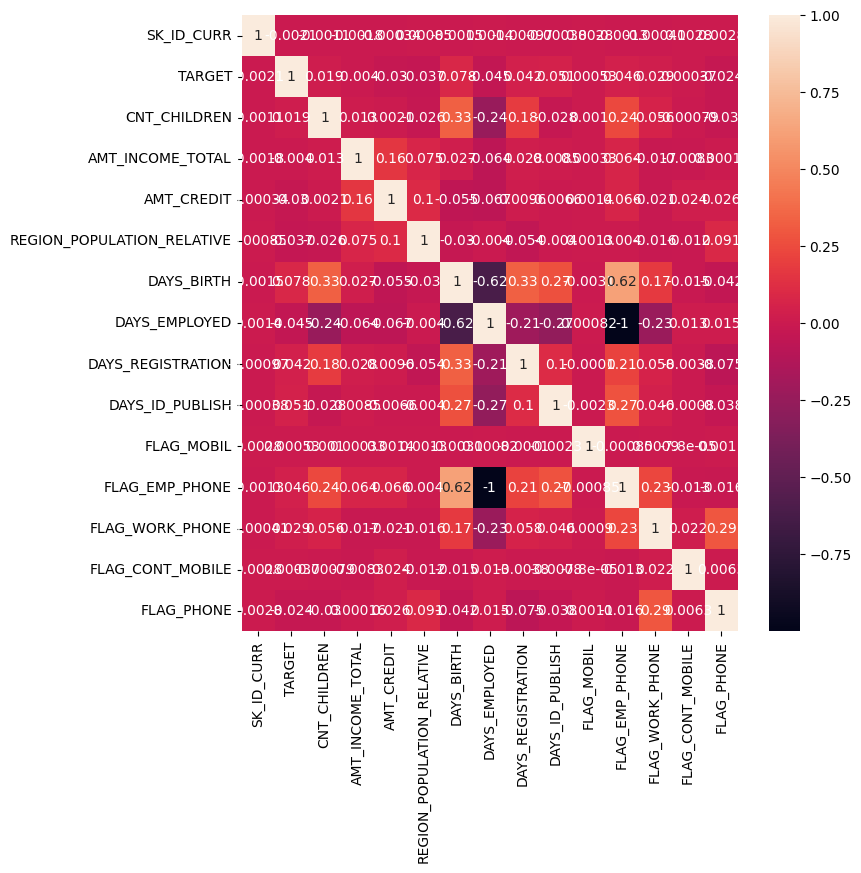

In [39]:
df_corr = df[list_numeric_columns].corr()
plt.figure(figsize=(8,8))
df_corr_for_view = df[list_numeric_columns[:15]].corr()
sns.heatmap(df_corr_for_view, annot=True)

In [40]:
# 너무 높은 correlation을 갖는 데이터를 삭제. 단, 해당 correlation값을 신뢰할 수 있는지 확인필요
# 기준은 절대값 0.75 이상
index_corr_over_75 = np.where((abs(df_corr)>0.75) & (df_corr != 1))
index_corr_over_75

(array([ 7, 11, 16, 17, 20, 21, 23, 24], dtype=int64),
 array([11,  7, 17, 16, 21, 20, 24, 23], dtype=int64))

In [41]:
len_corr_over_75 = len(index_corr_over_75[0])
left_columns = df_corr.columns[index_corr_over_75[0]]
right_columns = df_corr.columns[index_corr_over_75[1]]
for index in range(len_corr_over_75):
  print(left_columns[index], "<->", right_columns[index])

DAYS_EMPLOYED <-> FLAG_EMP_PHONE
FLAG_EMP_PHONE <-> DAYS_EMPLOYED
REGION_RATING_CLIENT <-> REGION_RATING_CLIENT_W_CITY
REGION_RATING_CLIENT_W_CITY <-> REGION_RATING_CLIENT
REG_REGION_NOT_WORK_REGION <-> LIVE_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION <-> REG_REGION_NOT_WORK_REGION
REG_CITY_NOT_WORK_CITY <-> LIVE_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY <-> REG_CITY_NOT_WORK_CITY


In [42]:
# 해당하는 인덱스를 출력
left_columns_over_75 = df_corr.columns[index_corr_over_75[0]]
right_columns_over_75 = df_corr.columns[index_corr_over_75[1]]

# 0.75 이상인 상관관계를 가진 열 리스트 출력
over_75_columns = list(set(left_columns_over_75).union(set(right_columns_over_75)))
print(len(over_75_columns), over_75_columns)

list_removed_by_correlation = over_75_columns

8 ['LIVE_REGION_NOT_WORK_REGION', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_EMPLOYED', 'REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'REG_REGION_NOT_WORK_REGION', 'REGION_RATING_CLIENT', 'LIVE_CITY_NOT_WORK_CITY']


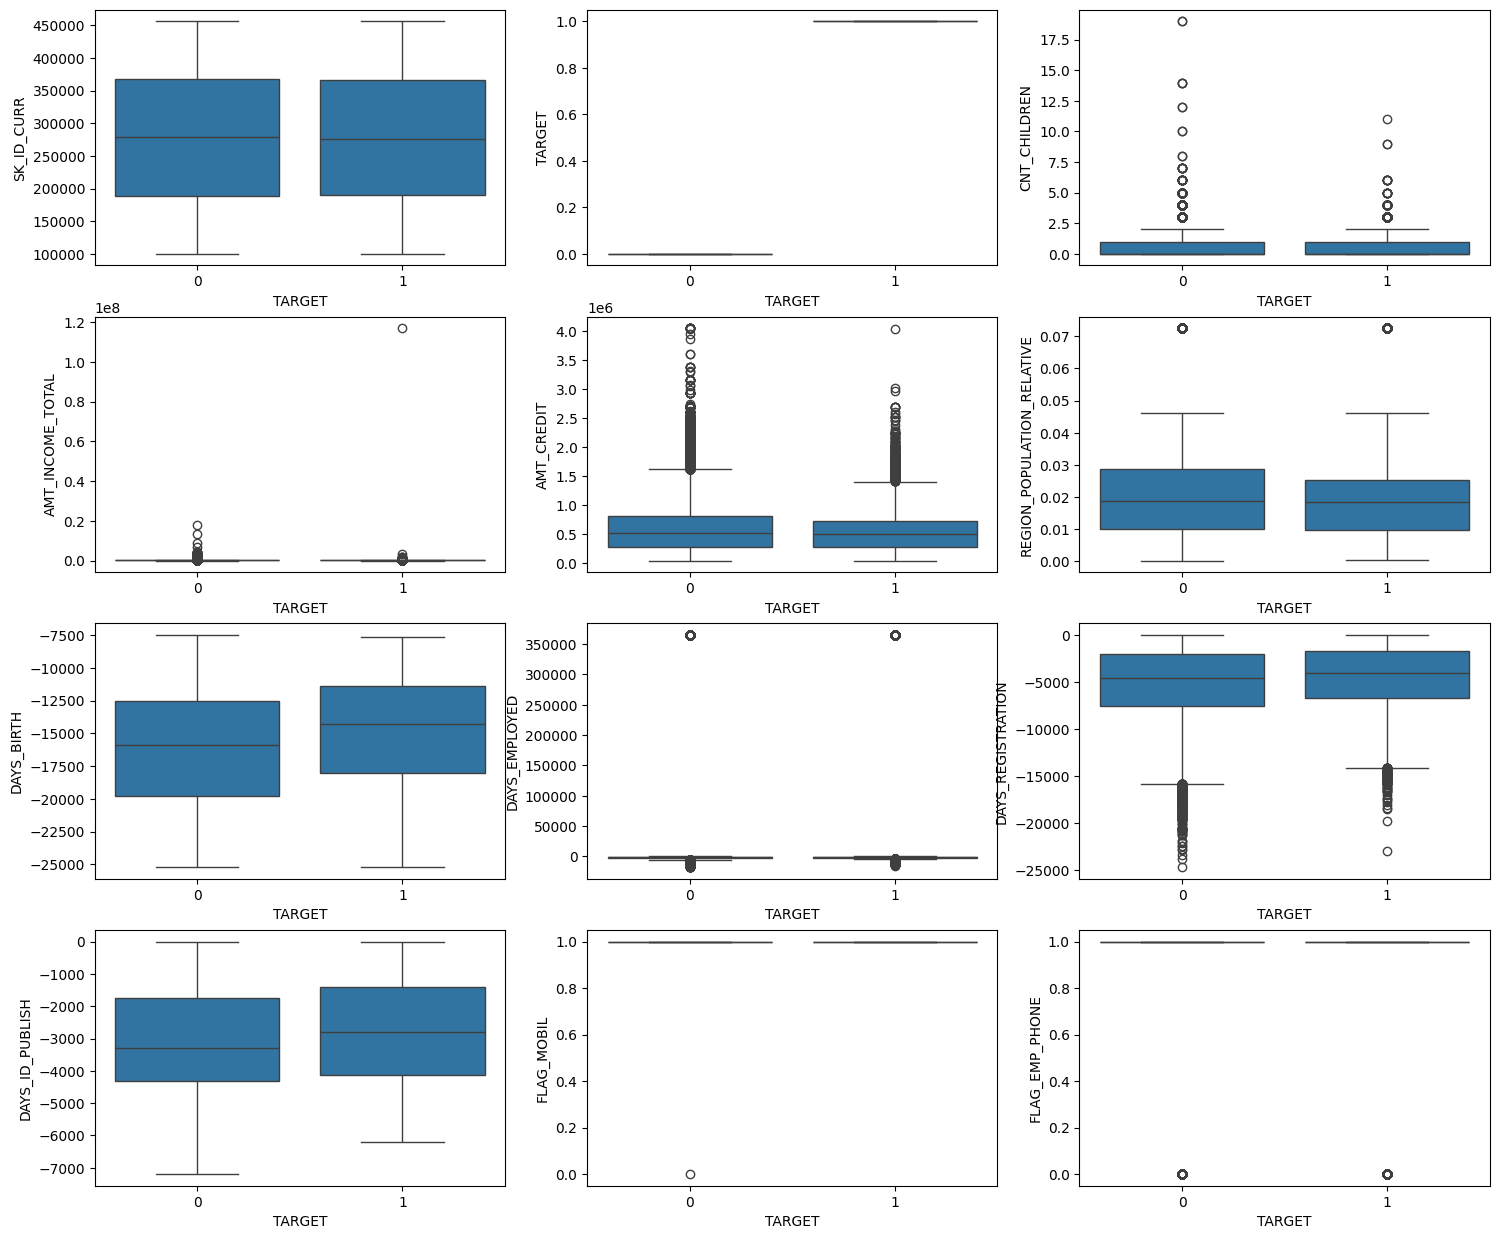

In [43]:
plt.figure(figsize=(18,12))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns[:12]:
    plt.subplot(4,3,x)
    x = x + 1
    sns.boxplot(data=df,x=target_column,y=column_name)
plt.show()

# 종속변수에 따른 previous 변수 분포 차이
# 종속변수에 따른 duration 변수 부노 차이

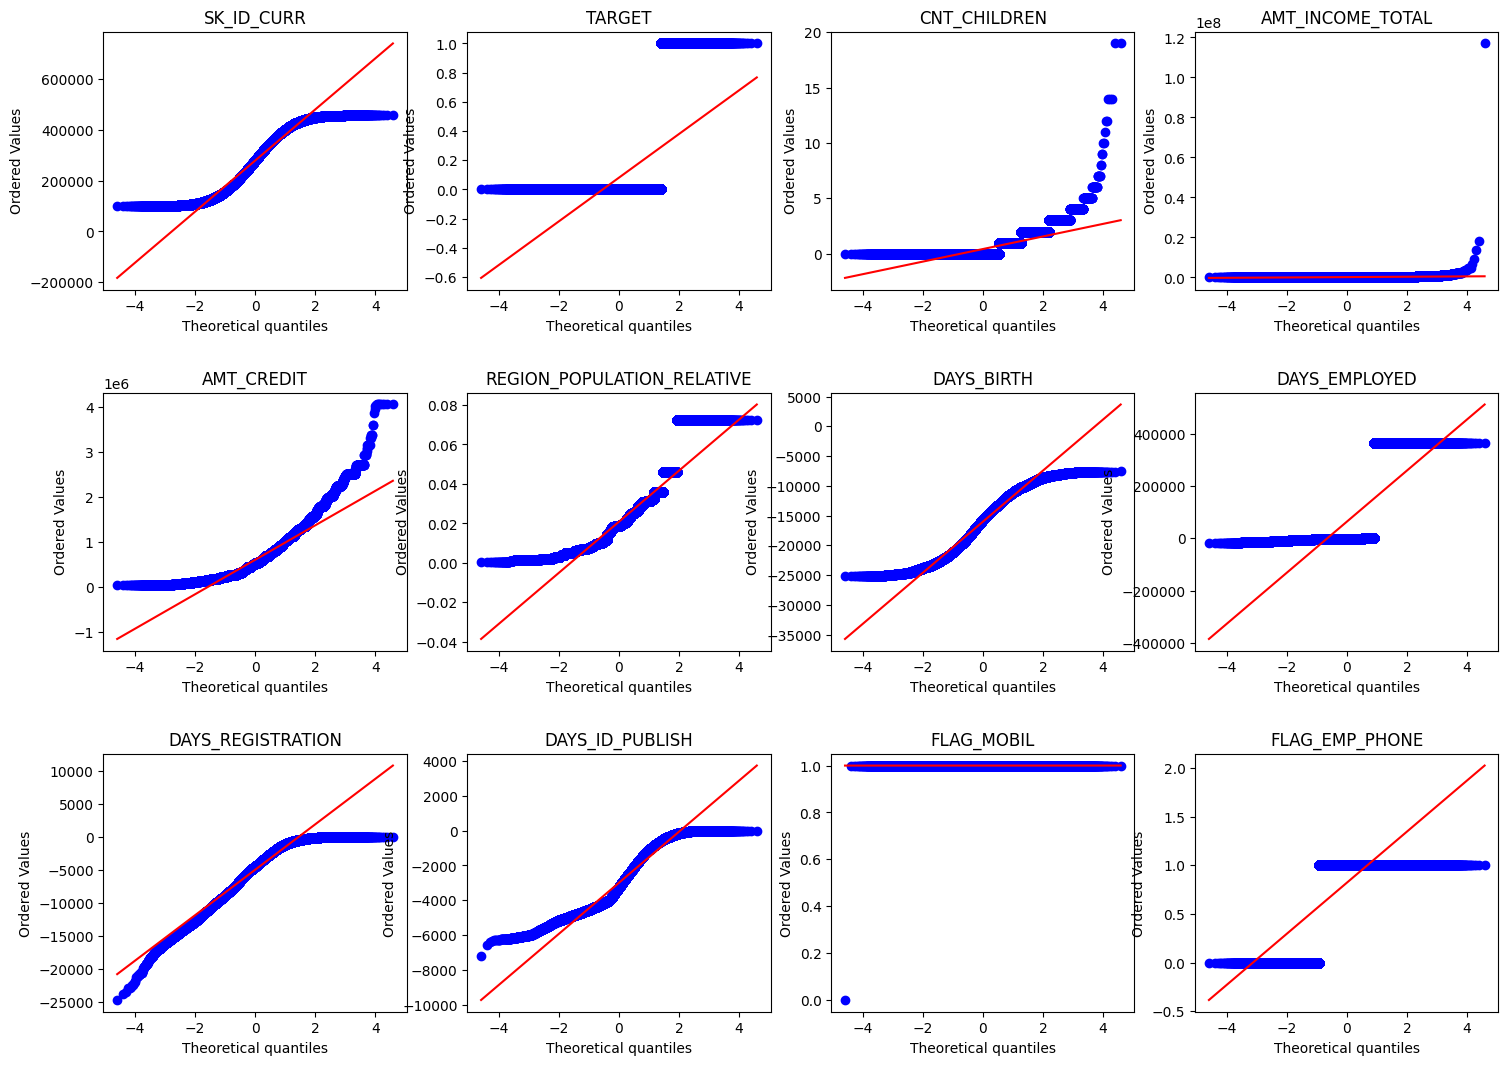

In [44]:
# numeric column 정규성 확인
plt.figure(figsize=(18,10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
for column_name in list_numeric_columns[:12]:
    plt.subplot(3,4,x)
    x = x+1

    stats.probplot(df[column_name], dist=stats.norm, plot=plt)

    plt.title(column_name)
plt.show()

In [45]:
list_column_normality = []
for column_name in list_numeric_columns:
  statistic, pvalue = stats.shapiro(df[column_name])
  if pvalue > 0.05:
    list_column_normality.append(column_name)
  print(column_name, ", statistic : ",statistic,", pvalue : ", pvalue)
print("정규성 만족하는 column 수 : ", len(list_column_normality))

p-value may not be accurate for N > 5000.


SK_ID_CURR , statistic :  0.9550306797027588 , pvalue :  0.0
TARGET , statistic :  0.3019893169403076 , pvalue :  0.0
CNT_CHILDREN , statistic :  0.6204872131347656 , pvalue :  0.0
AMT_INCOME_TOTAL , statistic :  0.13757330179214478 , pvalue :  0.0
AMT_CREDIT , statistic :  0.9057807922363281 , pvalue :  0.0
REGION_POPULATION_RELATIVE , statistic :  0.8773873448371887 , pvalue :  0.0
DAYS_BIRTH , statistic :  0.9696983098983765 , pvalue :  0.0
DAYS_EMPLOYED , statistic :  0.48046183586120605 , pvalue :  0.0
DAYS_REGISTRATION , statistic :  0.9538127779960632 , pvalue :  0.0
DAYS_ID_PUBLISH , statistic :  0.9414532780647278 , pvalue :  0.0
FLAG_MOBIL , statistic :  7.581710815429688e-05 , pvalue :  0.0
FLAG_EMP_PHONE , statistic :  0.4699161648750305 , pvalue :  0.0
FLAG_WORK_PHONE , statistic :  0.4895116090774536 , pvalue :  0.0
FLAG_CONT_MOBILE , statistic :  0.019069254398345947 , pvalue :  0.0
FLAG_PHONE , statistic :  0.563299298286438 , pvalue :  0.0
FLAG_EMAIL , statistic :  0.2

In [46]:
list_meaningful_column_by_kruskall = []

list_target_unique = df[target_column].unique()

for column_name in list_numeric_columns:
  list_by_target_value = []
  for target_value in list_target_unique:
    df_tmp = df[df[target_column]==target_value][column_name].dropna()
    list_by_target_value.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_by_target_value)
  if pvalue <= 0.05:
    list_meaningful_column_by_kruskall.append(column_name)
  print(column_name, ", ", statistic, ", ", pvalue)
print("all numerical columns : ", len(list_numeric_columns))
print("selected columns by kruskall : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

SK_ID_CURR ,  1.370228058542125 ,  0.2417727039623715
TARGET ,  307510.0000000002 ,  0.0
CNT_CHILDREN ,  123.92160815030569 ,  8.763844943369067e-29
AMT_INCOME_TOTAL ,  100.78573230936715 ,  1.0249194727095229e-23
AMT_CREDIT ,  94.57467370661574 ,  2.3601879517933197e-22
REGION_POPULATION_RELATIVE ,  287.225877020828 ,  1.999965312393663e-64
DAYS_BIRTH ,  1886.6682339638066 ,  0.0
DAYS_EMPLOYED ,  194.9950065681815 ,  2.5828625194268987e-44
DAYS_REGISTRATION ,  496.22371260929293 ,  6.304060666250903e-110
DAYS_ID_PUBLISH ,  848.7028561111996 ,  1.3917730427574987e-186
FLAG_MOBIL ,  0.08781521301661797 ,  0.766973253487896
FLAG_EMP_PHONE ,  650.1882366403233 ,  2.0331687175608547e-143
FLAG_WORK_PHONE ,  250.20150350117305 ,  2.3469842172088222e-56
FLAG_CONT_MOBILE ,  0.04212698269629933 ,  0.8373779100230132
FLAG_PHONE ,  174.27778758307286 ,  8.60837380645085e-40
FLAG_EMAIL ,  0.9507939485187525 ,  0.3295172868684461
REGION_RATING_CLIENT ,  1067.150828022951 ,  4.555784334213612e-234
R

In [47]:
list_selected_numerical = list_meaningful_column_by_kruskall.copy()
for column_name in list_removed_by_correlation:
  if (column_name in list_selected_numerical):
    list_selected_numerical.remove(column_name)

In [48]:
df_fs = df[list_meaningful_column_by_chi + list_selected_numerical]
df_fs.head(2)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,...,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,FLAG_DOCUMENT_21
0,Cash loans,M,N,Y,Working,Secondary / secondary special,Single / not married,House / apartment,WEDNESDAY,Business Entity Type 3,...,0,0,0,0,0,0,0,0,0,0
1,Cash loans,F,N,N,State servant,Higher education,Married,House / apartment,MONDAY,School,...,0,0,0,0,0,0,0,0,0,0


In [49]:
Y = df_fs[target_column]
X = df_fs.drop([target_column], axis=1)

In [50]:
X

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,...,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,FLAG_DOCUMENT_21
0,Cash loans,M,N,Y,Working,Secondary / secondary special,Single / not married,House / apartment,WEDNESDAY,Business Entity Type 3,...,0,0,0,0,0,0,0,0,0,0
1,Cash loans,F,N,N,State servant,Higher education,Married,House / apartment,MONDAY,School,...,0,0,0,0,0,0,0,0,0,0
2,Revolving loans,M,Y,Y,Working,Secondary / secondary special,Single / not married,House / apartment,MONDAY,Government,...,0,0,0,0,0,0,0,0,0,0
3,Cash loans,F,N,Y,Working,Secondary / secondary special,Civil marriage,House / apartment,WEDNESDAY,Business Entity Type 3,...,0,0,0,0,0,0,0,0,0,0
4,Cash loans,M,N,Y,Working,Secondary / secondary special,Single / not married,House / apartment,THURSDAY,Religion,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Working,Secondary / secondary special,Separated,With parents,THURSDAY,Services,...,0,1,0,0,0,0,0,0,0,0
307507,Cash loans,F,N,Y,Pensioner,Secondary / secondary special,Widow,House / apartment,MONDAY,XNA,...,0,0,0,0,0,0,0,0,0,0
307508,Cash loans,F,N,Y,Working,Higher education,Separated,House / apartment,THURSDAY,School,...,0,0,0,0,0,0,0,0,0,0
307509,Cash loans,F,N,Y,Commercial associate,Secondary / secondary special,Married,House / apartment,WEDNESDAY,Business Entity Type 1,...,0,0,0,0,0,0,0,0,0,0


In [51]:
Y

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [52]:
le = LabelEncoder()
le.fit(Y)
Y_encoded = le.transform(Y)

In [53]:
Y_encoded

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [54]:
list_categorical_columns = list(df_fs.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df_fs.select_dtypes(include=['float64','int64']).columns)
print(len(list_categorical_columns))
print(len(list_numeric_columns))

10
25


In [55]:
df_fs.head(1)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,...,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,FLAG_DOCUMENT_21
0,Cash loans,M,N,Y,Working,Secondary / secondary special,Single / not married,House / apartment,WEDNESDAY,Business Entity Type 3,...,0,0,0,0,0,0,0,0,0,0


In [56]:
scaler = MinMaxScaler()
list_numeric_columns = [col for col in list_numeric_columns if col != target_column]
X.loc[:, list_numeric_columns] = scaler.fit_transform(X[list_numeric_columns])
X.head(1)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,...,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,FLAG_DOCUMENT_21
0,Cash loans,M,N,Y,Working,Secondary / secondary special,Single / not married,House / apartment,WEDNESDAY,Business Entity Type 3,...,0,0,0,0,0,0,0,0,0,0


In [57]:
X_base = pd.get_dummies(X)
X_base.head(1)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,HOUR_APPR_PROCESS_START,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,0.0,0.001512,0.090287,0.256321,0.888839,0.85214,0.705433,0,1,0.434783,...,False,False,False,False,False,False,False,False,False,False


In [58]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y_encoded, test_size=0.2, stratify=Y_encoded)

In [60]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.create_experiment("bank_marketing_model")

'742071732687434128'

In [61]:
mlflow.set_experiment("bank_marketing_model")

<Experiment: artifact_location='mlflow-artifacts:/742071732687434128', creation_time=1736128257801, experiment_id='742071732687434128', last_update_time=1736128257801, lifecycle_stage='active', name='bank_marketing_model', tags={}>

Split 1
0  precision, recall, f1score :  (0.4596351308504671, 0.49999336720480747, 0.4789655939257236, None)
0  roc_auc_score :  0.6568781104252591
validation : precision, recall, f1score macro :  (0.45963348997544673, 0.49996462556156923, 0.47895151520286017, None)
validation : roc_auc_score :  0.646991218767675
Split 2
1  precision, recall, f1score :  (0.6263069105691057, 0.5000622631105213, 0.4791163156013917, None)
1  roc_auc_score :  0.6542371898782504
validation : precision, recall, f1score macro :  (0.45963480268613516, 0.4999823127807846, 0.47896034361524575, None)
validation : roc_auc_score :  0.652774045293602
Split 3


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


2  precision, recall, f1score :  (0.4596351308504671, 0.5, 0.47896863721852284, None)
2  roc_auc_score :  0.6517227160658691
validation : precision, recall, f1score macro :  (0.4596361153114482, 0.5, 0.4789691717284672, None)
validation : roc_auc_score :  0.6497476427461009


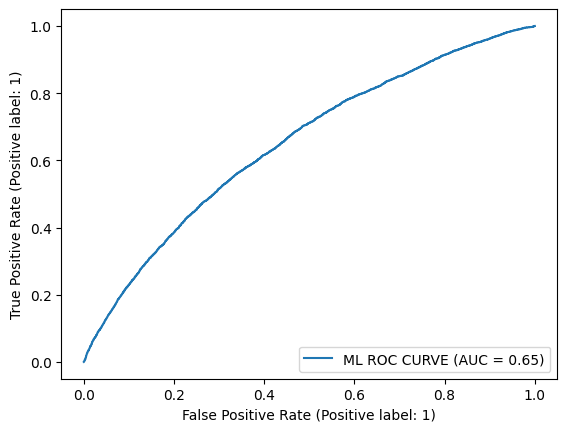

2025/01/06 10:51:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/06 10:51:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run mercurial-moose-820 at: http://127.0.0.1:5000/#/experiments/742071732687434128/runs/4f2b1b071ddb4437b243dc65e6420ee4.
2025/01/06 10:51:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/742071732687434128.


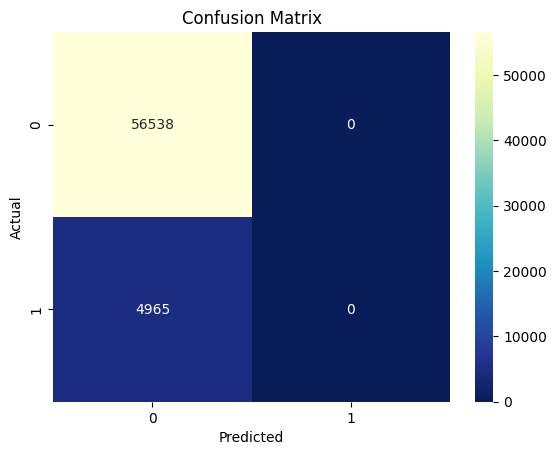

In [62]:
with mlflow.start_run():
    n_split = 3
    skf = StratifiedKFold(n_splits=n_split)
    skf.get_n_splits(X_base, Y_encoded)

    list_fold_result_test = []
    list_fold_result_validation = []
    list_fold_roc_test = []
    list_fold_roc_validation = []
    num_hidden_layer_sizes = 10
    activation = 'relu'
    learning_rate_init = 0.001

    mlflow.log_param("split num", n_split)
    mlflow.log_param("hidden_layer_sizes", num_hidden_layer_sizes)
    mlflow.log_param("activation", activation)
    mlflow.log_param("learning_rate_init", learning_rate_init)
    mlflow.log_param("sampling", "None")

    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        print("Split " + str(i+1))
        X_train_cv, X_test_cv = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

        # model set
        rf_clf = MLPClassifier(hidden_layer_sizes=num_hidden_layer_sizes, activation=activation, learning_rate_init=learning_rate_init)
        rf_clf.fit(X_train_cv, y_train_cv)

        # model inference on test set
        y_prd_test = rf_clf.predict(X_test_cv)
        y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:,-1]

        # score evaluation on test set
        prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average='macro')
        score_test = roc_auc_score(y_test_cv, y_prd_proba_test, average='macro')
        print(i, " precision, recall, f1score : ", prf_score_test)
        print(i, " roc_auc_score : ", score_test)
        list_fold_roc_test.append(score_test)
        list_fold_result_test.append(prf_score_test)

        # model inference on validation data set
        y_prd_validation = rf_clf.predict(X_validation)
        y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]

        # score evaluation on validation data set
        prf_score_validation_macro = precision_recall_fscore_support(y_validation, y_prd_validation, average='macro')
        score_validation = roc_auc_score(y_validation, y_prd_proba_validation, average='macro')
        print("validation : precision, recall, f1score macro : ", prf_score_validation_macro)
        print("validation : roc_auc_score : ", score_validation)
        list_fold_roc_validation.append(score_validation)
        list_fold_result_validation.append(prf_score_validation_macro)


    def get_prf_average(list_of_result):
        pre = 0
        rec = 0
        f1 = 0
        for result in list_fold_result_validation:
            pre += result[0]
            rec += result[1]
            f1 += result[2]
        return pre/n_split, rec/n_split, f1/n_split

    pre, rec, f1 = get_prf_average(list_fold_result_test)
    pre_val, rec_val, f1_val = get_prf_average(list_fold_result_validation)

    roc = sum(list_fold_roc_test)/n_split
    roc_val = sum(list_fold_roc_validation)/n_split

    mlflow.log_metric("precision_on_test", pre)
    mlflow.log_metric("recall_on_test", rec)
    mlflow.log_metric("f1score_on_test", f1)
    mlflow.log_metric("roc_on_test", roc)


    mlflow.log_metric("precision_on_validation", pre_val)
    mlflow.log_metric("recall_on_validation", rec_val)
    mlflow.log_metric("f1score_on_validation", f1_val)
    mlflow.log_metric("roc_on_validation", roc_val)


    def save_artifact(model, X_validation, y_validation, y_pred):
        roc_plot = RocCurveDisplay.from_estimator(model,X_validation,y_validation,name='ML ROC CURVE')
        # plt.savefig('model_roc_plot.png')
        plt.show()
        plt.clf()
        conf_matrix = confusion_matrix(y_validation, y_pred)
        ax=sns.heatmap(conf_matrix,annot=True,fmt='g',cmap='YlGnBu_r')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title("Confusion Matrix")
        # plt.savefig('model_conf_matrix.png')
        mlflow.log_artifact('model_roc_plot.png')
        mlflow.log_artifact('model_conf_matrix.png')
    save_artifact(rf_clf, X_validation, y_validation, y_prd_validation)
    mlflow.sklearn.log_model(rf_clf, "model")


mlflow.end_run()
